In [1]:
import cv2
import os
import numpy as np
import pickle as pk
import sys
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN ,KMeans
import pandas as pd
import numpy as np
import argparse
import cv2

/anaconda3/envs/virtualENV/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
os.chdir('/Users/abhinavrohilla/Data')

In [3]:
video_direc = '/Users/abhinavrohilla/Downloads/Funny Video Clips Bollywood Movie Actress Full Prank and Comedy Moments.mp4'
celebrities = "Katrina Kaif,Ranbir Kapoor,Shraddha Kapoor,Tiger Shroff,Anushka Sharma,Sonakshi Sinha,Priyanka Chopra,Sonam Kapoor,Amitabh Bachchan,Anil Kapoor,Anupam Kher,Arbaaz Khan,Arjun Kapoor,Varun Dhawan,Alia Bhatt,Deepika Padukone,Parineeti Chopra,Tapsee Pannu,Jackquline Fernandez,Salman Khan"
celeb_list = celebrities.split(',')

In [4]:
#CONVERTING VIDEO TO IMAGES AND SAVING IN CURRENT DIRECTORY
def video_to_images(video_direc):

    vid_cap = cv2.VideoCapture(video_direc)
    os.chdir("/Users/abhinavrohilla/video_images")
    image_vec = []
    success,image = vid_cap.read()
    count = 855
    while(success):
        success,image = vid_cap.read()
        cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
        image_vec.append(image)
        count += 1

In [5]:
# video_to_images("/Users/abhinavrohilla/Documents/ranbir.mp4")

In [6]:
#PARSE IMAGE FROM GOOGLE AND SAVE THEM IN CURRENT DIRECTORY
def parse_images_of_celebrities_from_google(celebrities,num_of_images):
    sys.path.append('/Users/abhinavrohilla/')
    from google_images_download.google_images_download import googleimagesdownload
    response = googleimagesdownload()
    arguments = {"keywords":celebrities,"limit":num_of_images,"print_urls":True}   #creating list of arguments
    #THIS WILL DOWNLOAD IMAGES TO THE GIVEN LOCATION
    os.chdir("/Users/abhinavrohilla/Data")
    paths = response.download(arguments)   #passing the arguments to the function

In [7]:
#parse_images_of_celebrities_from_google(celebrities,90)

In [8]:
#RETURN IMAGE IN VECTOR FORM
def image_to_vector(dataset="train"):
    bgr_images = []
    gray_scale_images = []
    not_recognized_images_count = 0
    labels = []
    if (dataset=="train"):
        for celeb in celeb_list:
            path = os.chdir('/Users/abhinavrohilla/Data/downloads/{}'.format(celeb))
            file_names = os.listdir()
            celeb_folder_gray = []
            celeb_folder_bgr = []
            celeb_label = []
            gray_scale_images.append(celeb_folder_gray)
            bgr_images.append(celeb_folder_bgr)
            labels.append(celeb_label)
            for image_name in range(len(file_names)):
                path = '/Users/abhinavrohilla/Data/downloads/{}/{}'.format(celeb,file_names[image_name])
                image = cv2.imread(path)    
                try:
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                    celeb_folder_gray.append(gray)
                    celeb_label.append(celeb)
                    celeb_folder_bgr.append(image)
                except:
                    not_recognized_images_count = not_recognized_images_count +1
                    image_name = image_name+1
                
    elif (dataset=="test"):
        path = os.chdir('/Users/abhinavrohilla/video_images')
        total_images_in_folder = os.listdir()
        for image_name in range(len(total_images_in_folder)-3):
            path = '/Users/abhinavrohilla/video_images/frame{}.jpg'.format(image_name)
            image = cv2.imread(path)
            
            try:
                gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                gray_scale_images.append(gray)
                bgr_images.append(image)
            except:
                not_recognized_images_count = not_recognized_images_count +1
                image_name = image_name+1

    return np.array(gray_scale_images),np.array(bgr_images),labels

In [9]:
gray_images,bgr_images,labels = image_to_vector("train")

In [10]:
test_gray_images,test_bgr_images,test_labels = image_to_vector("test")

In [11]:
# os.chdir("/Users/abhinavrohilla")
# pk.dump(gray_images,open("gray_images.p","wb"))
# pk.dump(labels,open("labels.p","wb"))
# # pk.dump(bgr_images,open("bgr_images.p","wb"))


In [12]:
# gray_images = pk.load(open("gray_images.p","rb"))
# labels = pk.load(open("labels.p","rb"))
# bgr_images = pk.load(open("bgr_images.p","rb"))

In [13]:
#WORKS ONLY FOR GRAY IMAGES
#THIS IS FOR CREATING TRAINING DATA FACES
def detect_face_and_crop(gray_images_vec):
    detector = dlib.get_frontal_face_detector()
    test_faces = []
    face_labels = []
    for folder in range(gray_images_vec.shape[0]):
        folder_faces = []
        folder_labels = []
        test_faces.append(folder_faces)
        folder_labels.append(folder_labels)
        for image in range(len(gray_images_vec[folder])):
            dict_faces = {}
            faces_ =  detector(gray_images_vec[folder][image],1)
            if (len(faces_)!=0):
                for num,dic_face in enumerate(faces_):
                    dict_faces[num] = dic_face
                for face in range(len(dict_faces)):
                    x = dict_faces[face].left()
                    y = dict_faces[face].top()
                    w = dict_faces[face].right() - x
                    h = dict_faces[face].bottom() - y        
                    img = cv2.rectangle(gray_images_vec[folder][image],(x,y),(x+w,y+h),(255,0,0),2)
                    bounding_box = img[y:y+h, x:x+w]
                    try:
                        test_face = cv2.resize(bounding_box,(160,160))
                        folder_faces.append(test_face)
                        folder_labels.append(celeb_list[folder])
                    except:
                        continue
    return np.array(test_faces),face_labels

In [14]:
#USING FACENET CONVERTING IMAGES VECTOR TO EMBEDDINGS
#SEND BGR IMAGE
def vector_to_embeddings(facess):
    sys.path.append("/Users/abhinavrohilla")
    from facenet.src import facenet
    model = "/Users/abhinavrohilla/Downloads/VGGFace2 pretrained model"
    sess = tf.Session()
    embeddingsss = []
    with sess.as_default():
        facenet.load_model(model)
        image_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        for folder in range(len(facess)):
            folder_list = []
            embeddingsss.append(folder_list)
            for face in range(len(facess[folder])):
                prewhiten_face = facenet.prewhiten(facess[folder][face])
                feed_dict = {image_placeholder:prewhiten_face.reshape(-1,160,160,3),phase_train_placeholder:False}
                embedds = sess.run(embeddings,feed_dict=feed_dict)
                folder_list.append(embedds)
    return embeddingsss

In [15]:
#TEST IMAGE EMBEDDING!
#THIS IS ONLY FOR 1 IMAGE AT A TIME
def test_embeddings(test_gray_images):
    
    detector = dlib.get_frontal_face_detector()
    dict_faces = {}
    test_embedds = []
    test_faces = []
    test_frames = []
    #LOAD FACENT MODEL
    #==============================================================>    
    sys.path.append("/Users/abhinavrohilla")
    from facenet.src import facenet
    model = "/Users/abhinavrohilla/Downloads/VGGFace2 pretrained model"
    sess = tf.Session()
    with sess.as_default():
        facenet.load_model(model)
        image_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    #==============================================================>    
        for imga in range(test_gray_images.shape[0]):
            faces_ = detector(test_gray_images[imga],1)
            #WORK ON THOSE FRAMES WHICH HAS FACES
            if (len(faces_)!=0):
                test_frames.append(test_gray_images[imga])
                faces_in_one_image_embedds = []
                faces_in_one_image_vector = []
                test_embedds.append(faces_in_one_image_embedds)
                test_faces.append(faces_in_one_image_vector)
                for num,faceq in enumerate(faces_):
                    dict_faces[num] = faceq
                for face in range(len(dict_faces)):
                    x = dict_faces[face].left()
                    y = dict_faces[face].top()
                    w = dict_faces[face].right() - x
                    h = dict_faces[face].bottom() - y  
                    img = cv2.rectangle(test_gray_images[imga],(x,y),(x+w,y+h),(255,0,0),2)
                    bounding_box = img[y:y+h, x:x+w]
                    test_face = cv2.cvtColor(bounding_box,cv2.COLOR_GRAY2BGR)
                    try:
                        test_face = cv2.resize(test_face,(160,160))
                        faces_in_one_image_vector.append(test_face)
                        prewhiten_face = facenet.prewhiten(test_face)
                        feed_dict = {image_placeholder:prewhiten_face.reshape(-1,160,160,3),phase_train_placeholder:False}
                        test_embeddings = sess.run(embeddings,feed_dict=feed_dict)
        #                 test_embeddings = vector_to_embeddings(test_face.reshape(1,160,160,3))
                        faces_in_one_image_embedds.append(test_embeddings)
                    except:
                        continue
    #         return np.array(test_embedds).reshape(len(dict_faces),512),test_faces
    return test_embedds,test_faces,test_frames

In [48]:
def generate_box_and_name(imagess,texts):
    face_cascade = cv2.CascadeClassifier('/anaconda3/pkgs/libopencv-3.4.2-h7c891bd_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    for image in range(len(imagess)):
        faces_ = face_cascade.detectMultiScale(imagess[image], 1.3, 5)
        dict_faces = {}
        for num,face in enumerate(faces_):
            dict_faces[num] = face
        for i,face in enumerate(dict_faces):
            for (x,y,w,h) in [dict_faces[face]]:
                img = cv2.rectangle(imagess[image],(x,y),(x+w,y+h),(255,0,0),2)
                try:
                    cv2.putText(imagess[image],texts[image][i][0],(x, y), cv2.FONT_HERSHEY_PLAIN, 3.5, (255, 0, 0), 2)
                except:
                    continue

In [17]:
def remove_uncessary_faces_fetched_from_google(face_embeddings,top_sort):    
    #CLEANING OTHER FACES FROM THE FACES FETCHED FROM GOOGLE
    #IN THIS MEAN IS TAKEN TO CLEAN OTHER FACES
    arg_list = []
    for i,celeb in enumerate(range(0,face_embeddings.shape[0],94)):
        celebrity = np.mean(face_embeddings[celeb:celeb+94],axis=0)
        cosine = cosine_similarity(celebrity.reshape(1,-1),face_embeddings)
        cosine = cosine.reshape(1,-1)
        cosine_sort = np.argsort(cosine).reshape(-1,1)
        cosine_top = cosine_sort[::-1]
        arg_list.append(cosine_top[:top_sort])
    #THIS LIST WILL HAVE INDEX OF FACES WITH NO NOISE FROM FACESS ARRAY
    #60 IMAGES PER CELEBRITY AND NO OTHER CELEBRITY WOULD BE PRESENT
    best_faces_of_celeb = np.array(arg_list).reshape(-1,top_sort)
    return best_faces_of_celeb

In [18]:
def create_training_data_with_labels(celeb_list,celeb_label_with_embeddings,pure_face_vectors):
    labels = []
    X = []
    vectors = []
    for i in range(len(celeb_label_with_embeddings)):
        for j in range(len(celeb_label_with_embeddings[celeb_list[i]])):
            labels.append(celeb_list[i])
            X.append(celeb_label_with_embeddings[celeb_list[i]][j])
            vectors.append(pure_face_vectors[celeb_list[i]][j])
    X = np.array(X)
    return X,labels,np.array(vectors)

In [19]:
#IN THIS DICTIONARY EVERY CELEBRITY HAS A AVERAGE MEAN OF THEIR FACES, WHICH YOU CAN SAY THE PROFILE FOR EACH CELEB
#IN THIS MEAN OF EACH CELEB IS THE PROFILE OF OF EACH CELEB
def profile_of_each_celeb(celeb_label_with_embeddings,celeb_list):
    celeb_embed_mean = {}
    for i in range(len(celeb_label_with_embeddings)):
        celeb_embed_mean[celeb_list[i]] = np.mean(celeb_label_with_embeddings[celeb_list[i]],axis=0).reshape(1,-1)
    return celeb_embed_mean

In [20]:
#THIS WILL RETURN THE NAMES OF CELEBRITIES IN PIC
#DONE IN BOTH EUCLEDIAN AND COSINE SIMILARITY MEASURE
#FOR EUCLEDIAN MATCHING FACES SHOULD HAVE MAXIMUM 
def names_of_celeb_in_video(test_embedds,celeb_embed_mean):
    celebrities_in_pic = []
    cosine = []
    eucledian = []
    for celeb in celeb_list:
#         aa = cosine_similarity(test_embedds,celeb_embed_mean[celeb])
        b = euclidean_distances(test_embedds,celeb_embed_mean[celeb])
#         cosine.append(aa)
        eucledian.append(b)
    max_similar_star = np.argmin(eucledian,axis=0)
#     max_similar_star = np.argmax(cosine,axis=0)
#     print (np.max(cosine,axis=0))
#     print (np.min(eucledian,axis=0))
    for i in max_similar_star:
         celebrities_in_pic.append(celeb_list[int(i)])
    return celebrities_in_pic

In [21]:
#137 noise faces
facess,labels = detect_face_and_crop(gray_images)

In [22]:
#FACENET REQUIRES BGR IMAGES
# faces_for_embeddings = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2BGR) for i in facess])
def gray_to_bgr_faces(facess):
    faces_for_embeddings = []
    for folder in range(len(facess)):
        image_list = []
        faces_for_embeddings.append(image_list)
        for face in range(len(facess[folder])):
            image_list.append(cv2.cvtColor(facess[folder][face],cv2.COLOR_GRAY2BGR))
    return faces_for_embeddings
#VECTORS TO EMBEDDINGS
faces_for_embeddings = gray_to_bgr_faces(facess)
face_embeddings = vector_to_embeddings(faces_for_embeddings)

Model directory: /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model/model-20180402-114759.ckpt-275


In [23]:
# best_faces_of_celeb = remove_uncessary_faces_fetched_from_google(face_embeddings,top_sort = 60)
#PURE IMAGES USING DBSCAN
def remove_uncessary_faces_fetched_from_google_using_DBSCAN(face_embeddings,facess,celeb_list):
    db_obj = DBSCAN(eps=0.9,min_samples=5)
    pure_face_embedds = {}
    pure_face_vectors = {}
    for folder in range(len(face_embeddings)):
            predictions = db_obj.fit_predict(np.array(face_embeddings[folder]).reshape(-1,512))
            indexed = pd.Series(predictions).value_counts().index[0]
            pure_face_embedds[celeb_list[folder]] = np.array(face_embeddings[folder]).reshape(-1,512)[predictions==indexed]
            pure_face_vectors[celeb_list[folder]] = np.array(facess[folder])[predictions==indexed]
    return pure_face_embedds, pure_face_vectors
pure_face_embedds,pure_face_vectors = remove_uncessary_faces_fetched_from_google_using_DBSCAN(face_embeddings,facess,celeb_list)

In [24]:
X,labels,X_vectors = create_training_data_with_labels(celeb_list,pure_face_embedds,pure_face_vectors)

In [25]:
test_face_embeddings,test_faces,test_frames = test_embeddings(test_gray_images)

Model directory: /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model/model-20180402-114759.ckpt-275


In [ ]:
# np.random.shuffle(data)
train_set = data[:1200]
test_set = data[1200:]
train_labels = train_set[:,-1]
test_labels = test_set[:,-1]
knn_obj.fit(train_set[:,:-1],train_labels)
predii = knn_obj.predict(test_set[:,:-1])
score = accuracy_score(predii,test_labels)
score_list.append(score)

In [116]:
#KNN WITH CROSS VALIDATION
#MODEL USING CROSS VALIDATION UPTO 30 Neighbours
from sklearn.model_selection import cross_val_score
data = np.concatenate((X,np.array(labels).reshape(-1,1)),axis=1)
score_list = []
for i in range(30):
    knn_obj = KNeighborsClassifier(n_neighbors=i+1)
    ss = cross_val_score(knn_obj,data[:,:-1],data[:,-1],cv=10,scoring='accuracy')
    score_list.append(np.mean(ss))
    N_neighbour = np.argmax(score_list)

In [117]:
np.max(score_list)

0.9762123656928461

In [128]:
np.random.shuffle(data)
test_set = data[1200:]
test_labels = test_set[:,-1]
predictions_using_mean =names_of_celeb_in_video(test_set[:,:-1],celeb_embed_mean)
accuracy_score(predictions_using_mean,test_labels)

0.9715302491103203

In [90]:
#MODEL WITH KNN
knn_obj = KNeighborsClassifier(n_neighbors=12)
knn_obj.fit(train_set[:,:-1],train_labels)
predii = knn_obj.predict(test_set[:,:-1])
accuracy_score(predii,test_labels)

0.9786476868327402

In [27]:
#KNN MODEL ON VIDEO IMAGES
knn_obj = KNeighborsClassifier(n_neighbors=13)
knn_obj.fit(X,labels)
final_prediction_knn = []
for image in range(len(test_face_embeddings)):
    prediction = []
    for face in range(len(test_face_embeddings[image])):
        predic = knn_obj.predict(test_face_embeddings[image][face])
        prediction.append(predic)
    final_prediction_knn.append(prediction)

In [129]:
#MODEL_1 with COSINE AND EUCLEDIAN DISTANCE
celeb_embed_mean = profile_of_each_celeb(pure_face_embedds,celeb_list)
final_prediction = []
for image in range(len(test_face_embeddings)):
    prediction = []
    for face in range(len(test_face_embeddings[image])):
        predic = names_of_celeb_in_video(test_face_embeddings[image][face],celeb_embed_mean)
        prediction.append(predic)
    final_prediction.append(prediction)

In [51]:
# generate_box_and_name(test_frames,final_prediction_knn)
frame_width,frame_height =test_frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('outputttt.avi',fourcc, 20.0, (frame_width,frame_height))

In [52]:
for i in range(len(test_frames)):
        frame = test_frames[i]
        # write the flipped frame
        frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2BGR)
        out.write(frame)
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
# Release everything if job is finished
out.release()
cv2.destroyAllWindows()

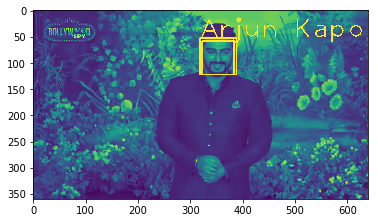

In [56]:
plt.imshow(test_frames[300])